<a href="https://colab.research.google.com/github/huongnd12/credit-card-fraud-detection/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import NearMiss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!gdown 1_iSLSXl_MuFmiOzGyGUCVzQhYpUZXJGV

Downloading...
From: https://drive.google.com/uc?id=1_iSLSXl_MuFmiOzGyGUCVzQhYpUZXJGV
To: /content/creditcard.csv
100% 151M/151M [00:05<00:00, 27.0MB/s]


# 1.Introduction

In this project, I will use various predictive models and compare their performance in detecting whether a transaction is a normal payment or a fraud.

Specifically, the goals in this project include:
- Dataset EDA
- Dealing with imbalanced data between Fraud and Non-Fraud transactions
- Training and evaluating Classifiers to choose which one has a higher accuracy

# 2.EDA

In [ ]:
df = pd.read_csv('/content/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset contains transactions made by credit cards in September 2013 by European cardholders.

The dataset contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


It should be noted that the transaction amount in the `Amount`column has significant outliers. In detail, the mean and standard deviation respectively are 88.35 and 250.12, and 75% of transactions has an amount of under 77.165.

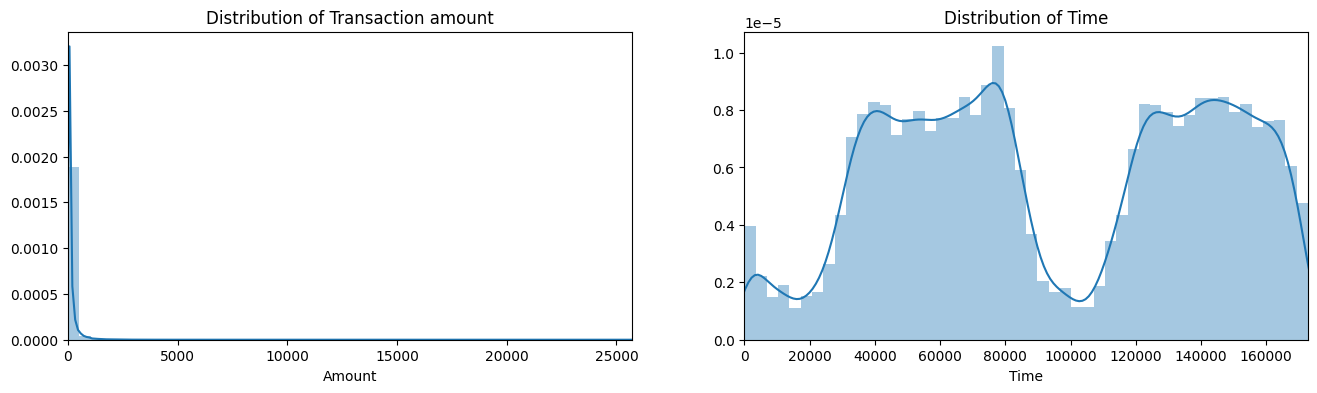

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))

sns.distplot(df['Amount'], ax=axes[0])
axes[0].set_title('Distribution of Transaction amount')
axes[0].set_ylabel('')
axes[0].set_xlim(min(df['Amount']), max(df['Amount']))

sns.distplot(df['Time'], ax=axes[1])
axes[1].set_title('Distribution of Time')
axes[1].set_ylabel('')
axes[1].set_xlim(min(df['Time']), max(df['Time']))

plt.show()


In [ ]:
c0 = df[df['Class'] == 0]
c1 = df[df['Class'] == 1]
print('Transaction amount statistic summary:')
print('-'*10)
print('Non-Fraud:')
print(c0.describe()['Amount'])
print('-'*10)
print('Fraud:')
print(c1.describe()['Amount'])

Transaction amount statistic summary:
----------
Non-Fraud:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
----------
Fraud:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


Features will be scaled to the same interval for modelling in the next section.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
print('Number of null values:')
print(df.isnull().sum())

Number of null values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [ ]:
class_dist = df['Class'].value_counts(normalize=True)*100
print(f'Non-Fraud: {class_dist[0]:.2f}%')
print(f'Fraud: {class_dist[1]:.2f}%')

Non-Fraud: 99.83%
Fraud: 0.17%


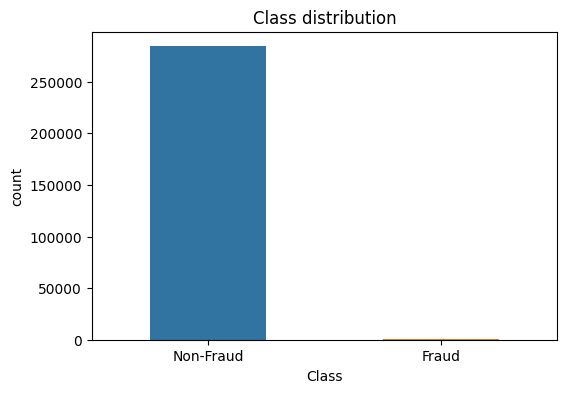

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Class', width=0.5)
plt.xticks(ticks=[0,1], labels=['Non-Fraud','Fraud'])
plt.title('Class distribution')
plt.show()

The dataset is seriously imbalanced. In which, most of transactions are Non-Fraud. This will create error in predictive models' result since they will assume that transactions are Non-Fraud. However, our goal is to detect fraud transactions so models should classify correctly transactions in this class.

Oversampling and Undersampling techniques will be implemented in the next section.

# 3.Data Preprocessing

## 3.1.Data Splitting and Scaling

In [ ]:
X, y = df.drop(['Class'], axis=1).to_numpy(), df['Class'].to_numpy()

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(iter(sss.split(X, y)))

original_X_train = X[train_idx]
original_X_test = X[test_idx]

original_y_train = y[train_idx]
original_y_test = y[test_idx]

In [ ]:
train_sz = np.unique(original_y_train, return_counts=True)
test_sz = np.unique(original_y_test, return_counts=True)
print('Train size:')
print(f'  {train_sz[0][0]}: {train_sz[1][0]}')
print(f'  {train_sz[0][1]}: {train_sz[1][1]}')
print('Test size:')
print(f'  {test_sz[0][0]}: {test_sz[1][0]}')
print(f'  {test_sz[0][1]}: {test_sz[1][1]}')

Train size:
  0: 227451
  1: 394
Test size:
  0: 56864
  1: 98


In [ ]:
scaler = StandardScaler()
original_X_train = scaler.fit_transform(original_X_train)
original_X_test = scaler.transform(original_X_test)

## 3.2. Oversampling with BorderlineSMOTE

BorderlineSMOTE is a variant of the original SMOTE algorithm in which the synthetic points might be generated inside the majority class region. Borderline samples will be detected and used to generate new synthetic samples.

In [ ]:
over = BorderlineSMOTE(random_state=42)
X_over, y_over = over.fit_resample(original_X_train, original_y_train)

In [ ]:
df_over = pd.DataFrame(np.hstack([X_over, y_over[:, np.newaxis]]), columns=df.columns)

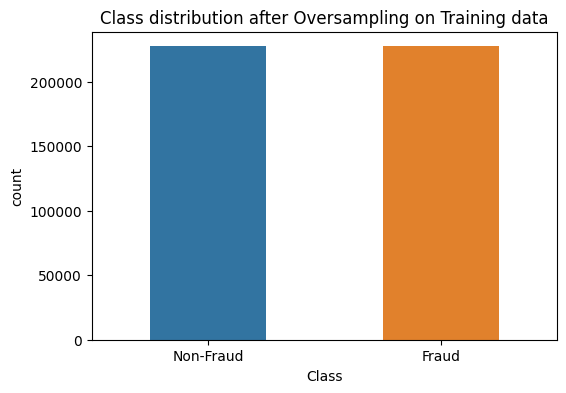

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_over, x='Class', width=0.5)
plt.xticks(ticks=[0,1], labels=['Non-Fraud','Fraud'])
plt.title('Class distribution after Oversampling on Training data')
plt.show()

**Deeper EDA on oversampling dataset**

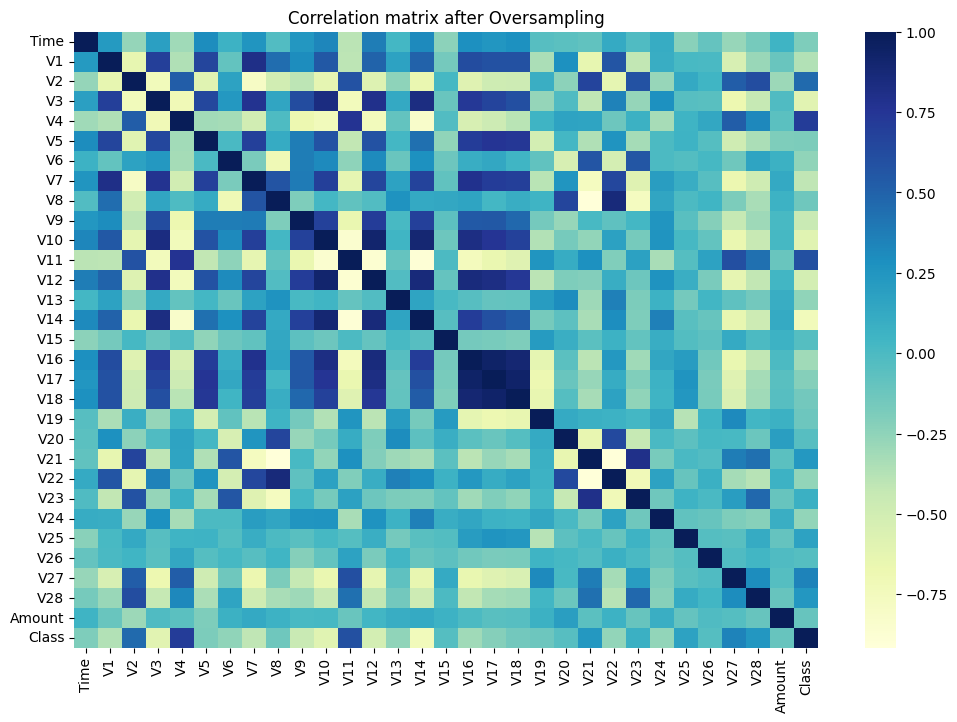

In [ ]:
corr_matrix_over = df_over.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix_over, cmap="YlGnBu")
plt.title('Correlation matrix after Oversampling')
plt.show()

From the above correlation heatmap, we can easily observe that:
- **V2**, **V4** and **V11** have **positive** relationship with Fraud possibility. The higher these features, the higher possibility of Fraud transaction
- **V3**, **V10** and **V14** have **negative** relationship with Fraud possibility. The lower these features, the higher possibility of Fraud transaction

# 4.Modelling

In [ ]:
metrics = {'model_name': [],
           'train_score': [],
           'test_score': [],
           'confusion_matrix': [],
           'classification_report': [],
           'fpr': [],
           'tpr': [],
           'threshold_roc': [],
           'roc_auc': [],
           'precision': [],
           'recall': [],
           'threshold_pr': [],
           'pr_auc': []}

**K-Nearest Neighbors**

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')
knn.fit(X_over, y_over)

# Predict
knn_ytrain_pred = knn.predict(X_over)
knn_ytest_pred = knn.predict(original_X_test)

# Accuracy score
knn_train_score = accuracy_score(y_over, knn_ytrain_pred)
knn_test_score = accuracy_score(original_y_test, knn_ytest_pred)

# Confusion matrix
knn_cf = confusion_matrix(original_y_test, knn_ytest_pred)
knn_clf_rp = classification_report(original_y_test, knn_ytest_pred)

# Predict prob
knn_ytest_prob = knn.predict_proba(original_X_test)[:, 1]

# ROC
knn_fpr, knn_tpr, knn_thres_roc = roc_curve(original_y_test, knn_ytest_prob)
knn_roc_auc = roc_auc_score(original_y_test, knn_ytest_prob)

# PR
knn_precision, knn_recall, knn_thresh_pr = precision_recall_curve(original_y_test, knn_ytest_prob)
knn_pr_auc = auc(knn_recall, knn_precision)


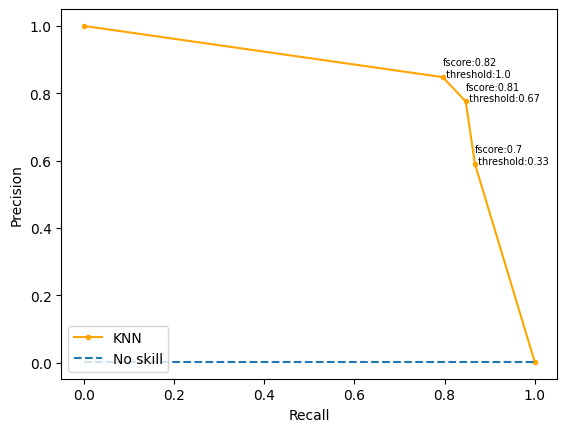

In [ ]:
no_skill = len(original_y_test[original_y_test==1]) / len(original_y_test)
knn_fscore = (2 * knn_precision * knn_recall) / (knn_precision + knn_recall)
plt.plot(knn_recall, knn_precision, marker='.', color='orange', label='KNN')
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No skill')
for i, (x, y) in enumerate(zip(knn_recall[1:-1], knn_precision[1:-1])):
  plt.text(x, y,
           f'fscore:{round(knn_fscore[i+1], 2)}\n threshold:{round(knn_thresh_pr[i+1], 2)}',
           fontdict={'size': 7})
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

In [ ]:
print('Prediction Prob. >= 0.33')
print(classification_report(original_y_test, (knn_ytest_prob >= 1/3).astype(int)))
print('\n')
print('Prediction Prob. >= 0.5 (Default)')
print(knn_clf_rp)

Prediction Prob. >= 0.33
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.59      0.87      0.70        98

    accuracy                           1.00     56962
   macro avg       0.80      0.93      0.85     56962
weighted avg       1.00      1.00      1.00     56962



Prediction Prob. >= 0.5 (Default)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.85      0.81        98

    accuracy                           1.00     56962
   macro avg       0.89      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
metrics['model_name'].append('KNN')
metrics['train_score'].append(knn_train_score)
metrics['test_score'].append(knn_test_score)
metrics['confusion_matrix'].append(knn_cf.tolist())
metrics['classification_report'].append(knn_clf_rp)
metrics['fpr'].append(knn_fpr.tolist())
metrics['tpr'].append(knn_tpr.tolist())
metrics['threshold_roc'].append(knn_thres_roc.tolist())
metrics['roc_auc'].append(knn_roc_auc)
metrics['precision'].append(knn_precision.tolist())
metrics['recall'].append(knn_recall.tolist())
metrics['threshold_pr'].append(knn_thresh_pr.tolist())
metrics['pr_auc'].append(knn_pr_auc)

**Random Forest**

In [ ]:
# Random Forest

rf = RandomForestClassifier()
rf.fit(X_over, y_over)

# Predict
rf_ytrain_pred = rf.predict(X_over)
rf_ytest_pred = rf.predict(original_X_test)

# Accuracy score
rf_train_score = accuracy_score(y_over, rf_ytrain_pred)
rf_test_score = accuracy_score(original_y_test, rf_ytest_pred)

# Confusion matrix
rf_cf = confusion_matrix(original_y_test, rf_ytest_pred)
rf_clf_rp = classification_report(original_y_test, rf_ytest_pred)

# Predict prob
rf_ytest_prob = rf.predict_proba(original_X_test)[:, 1]

# ROC
rf_fpr, rf_tpr, rf_thres_roc = roc_curve(original_y_test, rf_ytest_prob)
rf_roc_auc = roc_auc_score(original_y_test, rf_ytest_prob)

# PR
rf_precision, rf_recall, rf_thresh_pr = precision_recall_curve(original_y_test, rf_ytest_prob)
rf_pr_auc = auc(rf_recall, rf_precision)


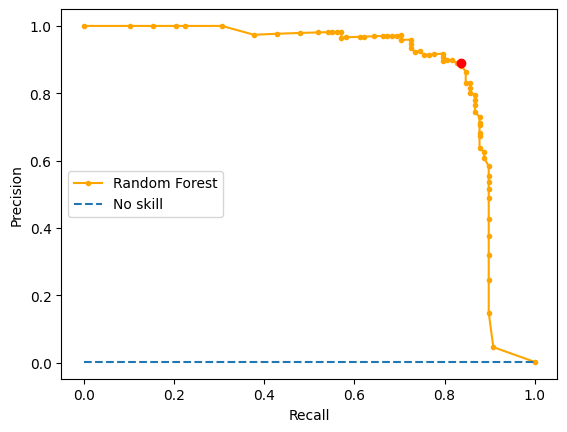

In [ ]:
no_skill = len(original_y_test[original_y_test==1]) / len(original_y_test)
rf_fscore = (2 * rf_precision * rf_recall) / (rf_precision + rf_recall)
plt.plot(rf_recall, rf_precision, marker='.', color='orange', label='Random Forest')
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No skill')
plt.plot(rf_recall[np.argmax(rf_fscore)], rf_precision[np.argmax(rf_fscore)], 'ro')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [ ]:
print('Precision-Recall Threshold reaches the highest f1 score:', rf_thresh_pr[np.argmax(rf_fscore)])

Precision-Recall Threshold reaches the highest f1 score: 0.34


In [ ]:
print('Prediction Prob. >= 0.34 (Highest F1-Score)')
print(classification_report(original_y_test, (rf_ytest_prob >= 0.34).astype(int)))
print('\n')
print('Prediction Prob. >= 0.5 (Default)')
print(rf_clf_rp)

Prediction Prob. >= 0.34 (Highest F1-Score)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



Prediction Prob. >= 0.5 (Default)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.77      0.83        98

    accuracy                           1.00     56962
   macro avg       0.96      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
metrics['model_name'].append('Random Forest')
metrics['train_score'].append(rf_train_score)
metrics['test_score'].append(rf_test_score)
metrics['confusion_matrix'].append(rf_cf.tolist())
metrics['classification_report'].append(rf_clf_rp)
metrics['fpr'].append(rf_fpr.tolist())
metrics['tpr'].append(rf_tpr.tolist())
metrics['threshold_roc'].append(rf_thres_roc.tolist())
metrics['roc_auc'].append(rf_roc_auc)
metrics['precision'].append(rf_precision.tolist())
metrics['recall'].append(rf_recall.tolist())
metrics['threshold_pr'].append(rf_thresh_pr.tolist())
metrics['pr_auc'].append(rf_pr_auc)

**XGBoost**

In [ ]:
# XGBoost

xgb = XGBClassifier()
xgb.fit(X_over, y_over)

# Predict
xgb_ytrain_pred = xgb.predict(X_over)
xgb_ytest_pred = xgb.predict(original_X_test)

# Accuracy score
xgb_train_score = accuracy_score(y_over, xgb_ytrain_pred)
xgb_test_score = accuracy_score(original_y_test, xgb_ytest_pred)

# Confusion matrix
xgb_cf = confusion_matrix(original_y_test, xgb_ytest_pred)
xgb_clf_rp = classification_report(original_y_test, xgb_ytest_pred)

# Predict prob
xgb_ytest_prob = xgb.predict_proba(original_X_test)[:, 1]

# ROC
xgb_fpr, xgb_tpr, xgb_thres_roc = roc_curve(original_y_test, xgb_ytest_prob)
xgb_roc_auc = roc_auc_score(original_y_test, xgb_ytest_prob)

# PR
xgb_precision, xgb_recall, xgb_thresh_pr = precision_recall_curve(original_y_test, xgb_ytest_prob)
xgb_pr_auc = auc(xgb_recall, xgb_precision)


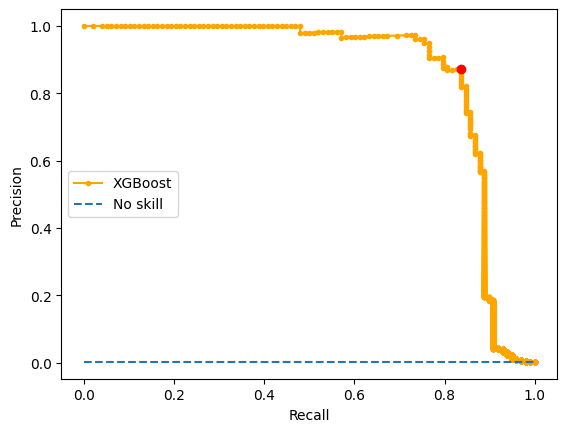

In [ ]:
no_skill = len(original_y_test[original_y_test==1]) / len(original_y_test)
xgb_fscore = (2 * xgb_precision * xgb_recall) / (xgb_precision + xgb_recall)
plt.plot(xgb_recall, xgb_precision, marker='.', color='orange', label='XGBoost')
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No skill')
plt.plot(xgb_recall[np.argmax(xgb_fscore)], xgb_precision[np.argmax(xgb_fscore)], 'ro')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [ ]:
print('Precision-Recall Threshold reaches the highest f1 score:', xgb_thresh_pr[np.argmax(xgb_fscore)])

Precision-Recall Threshold reaches the highest f1 score: 0.6299712


In [ ]:
print('Prediction Prob. >= 0.63 (Highest F1-Score)')
print(classification_report(original_y_test, (xgb_ytest_prob >= 0.63).astype(int)))
print('\n')
print('Prediction Prob. >= 0.5 (Default)')
print(xgb_clf_rp)

Prediction Prob. >= 0.63 (Highest F1-Score)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



Prediction Prob. >= 0.5 (Default)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
metrics['model_name'].append('XGBoost')
metrics['train_score'].append(xgb_train_score)
metrics['test_score'].append(xgb_test_score)
metrics['confusion_matrix'].append(xgb_cf.tolist())
metrics['classification_report'].append(xgb_clf_rp)
metrics['fpr'].append(xgb_fpr.tolist())
metrics['tpr'].append(xgb_tpr.tolist())
metrics['threshold_roc'].append(xgb_thres_roc.tolist())
metrics['roc_auc'].append(xgb_roc_auc)
metrics['precision'].append(xgb_precision.tolist())
metrics['recall'].append(xgb_recall.tolist())
metrics['threshold_pr'].append(xgb_thresh_pr.tolist())
metrics['pr_auc'].append(xgb_pr_auc)

**Logistic Regression**

In [ ]:
weight0 = len(np.where(original_y_train == 0)[0]) / len(original_y_train)

In [ ]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_over, y_over)

# Predict
logreg_ytrain_pred = logreg.predict(X_over)
logreg_ytest_pred = logreg.predict(original_X_test)

# Accuracy score
logreg_train_score = accuracy_score(y_over, logreg_ytrain_pred)
logreg_test_score = accuracy_score(original_y_test, logreg_ytest_pred)

# Confusion matrix
logreg_cf = confusion_matrix(original_y_test, logreg_ytest_pred)
logreg_clf_rp = classification_report(original_y_test, logreg_ytest_pred)

# Predict prob
logreg_ytest_prob = logreg.predict_proba(original_X_test)[:, 1]

# ROC
logreg_fpr, logreg_tpr, logreg_thres_roc = roc_curve(original_y_test, logreg_ytest_prob)
logreg_roc_auc = roc_auc_score(original_y_test, logreg_ytest_prob)

# PR
logreg_precision, logreg_recall, logreg_thresh_pr = precision_recall_curve(original_y_test, logreg_ytest_prob)
logreg_pr_auc = auc(logreg_recall, logreg_precision)


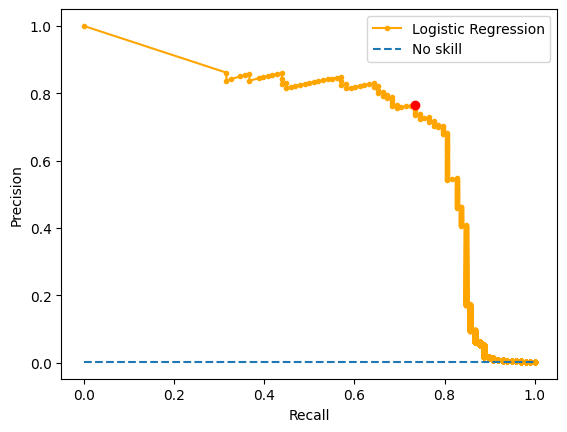

In [ ]:
no_skill = len(original_y_test[original_y_test==1]) / len(original_y_test)
logreg_fscore = (2 * logreg_precision * logreg_recall) / (logreg_precision + logreg_recall)
plt.plot(logreg_recall, logreg_precision, marker='.', color='orange', label='Logistic Regression')
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No skill')
plt.plot(logreg_recall[np.argmax(logreg_fscore)], logreg_precision[np.argmax(logreg_fscore)], 'ro')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [ ]:
print('Precision-Recall Threshold reaches the highest f1 score:', logreg_thresh_pr[np.argmax(logreg_fscore)])

Precision-Recall Threshold reaches the highest f1 score: 0.9999988099574957


In [ ]:
print('Prediction Prob. >= 0.99999 (Highest F1-Score)')
print(classification_report(original_y_test, (logreg_ytest_prob >= 0.99999).astype(int)))
print('\n')
print('Prediction Prob. >= 0.5 (Default)')
print(logreg_clf_rp)

Prediction Prob. >= 0.99999 (Highest F1-Score)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.76      0.74        98

    accuracy                           1.00     56962
   macro avg       0.86      0.88      0.87     56962
weighted avg       1.00      1.00      1.00     56962



Prediction Prob. >= 0.5 (Default)
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.86      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.92      0.59     56962
weighted avg       1.00      0.99      0.99     56962



In [ ]:
metrics['model_name'].append('Logistic Regression')
metrics['train_score'].append(logreg_train_score)
metrics['test_score'].append(logreg_test_score)
metrics['confusion_matrix'].append(logreg_cf.tolist())
metrics['classification_report'].append(logreg_clf_rp)
metrics['fpr'].append(logreg_fpr.tolist())
metrics['tpr'].append(logreg_tpr.tolist())
metrics['threshold_roc'].append(logreg_thres_roc.tolist())
metrics['roc_auc'].append(logreg_roc_auc)
metrics['precision'].append(logreg_precision.tolist())
metrics['recall'].append(logreg_recall.tolist())
metrics['threshold_pr'].append(logreg_thresh_pr.tolist())
metrics['pr_auc'].append(logreg_pr_auc)

In [ ]:
with open('metrics_summary.json', 'w') as f:
    json.dump(metrics, f)

# 5.Summary of Model evaluation

In [ ]:
with open('metrics_summary.json', 'r') as f:
    metrics_summary = json.load(f)

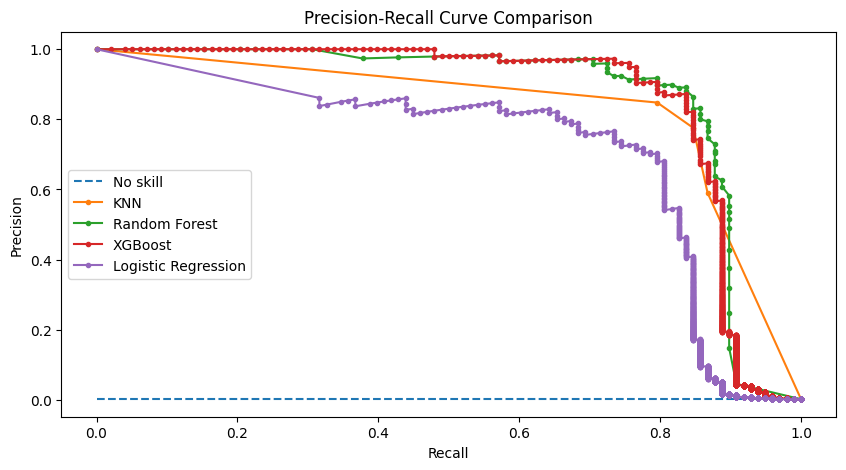

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No skill')
for i in range(4):
  plt.plot(metrics_summary['recall'][i], metrics_summary['precision'][i], marker='.', label=metrics_summary['model_name'][i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()

In [ ]:
print('Summary of Precision-Recall AUC Score:')
for i in range(4):
  model_name = metrics_summary['model_name'][i]
  pr_auc = metrics_summary['pr_auc'][i]
  print(f'  {model_name:<20}: {pr_auc:.4f}')

Summary of Precision-Recall AUC Score:
  KNN                 : 0.8300
  Random Forest       : 0.8654
  XGBoost             : 0.8610
  Logistic Regression : 0.7143


The comparison of Precision-Recall Curve and Precision-Recall AUC Score show better classification on validation dataset under algorithms `Random Forest` and `XGBoost`. In addition, XGBoost takes less time to train and much faster than with Random Forest.

# 6.Application of Feed Forward Neural Network

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import time

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    super(CustomDataset, self).__init__()
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]


In [ ]:
train_dataset = CustomDataset(X_over, y_over)
test_dataset = CustomDataset(original_X_test, original_y_test)

train_batch_size = 512
test_batch_size = 8
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=train_batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=test_batch_size,
                         shuffle=False)

In [ ]:
def train(data_loader, model, criterion, optimizer, device):
  model.train()
  train_loss, train_acc = 0, 0
  for images, labels in data_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)

    loss = criterion(outputs, labels)
    train_loss += loss.item()
    train_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader.dataset)
  return train_loss, train_acc

In [ ]:
def evaluate(data_loader, model, criterion, device):
  model.eval()
  val_loss, val_acc = 0, 0
  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      val_loss += criterion(outputs, labels).item()
      val_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()

  val_loss /= len(data_loader)
  val_acc /= len(data_loader.dataset)
  return val_loss, val_acc


In [ ]:
def fit(train_loader, val_loader, model, criterion, optimizer, device, num_epochs):
  train_losses, val_losses = [], []
  train_accuracy, val_accuracy = [], []
  times = []
  for epoch in range(1, num_epochs + 1):
    begin = time.time()

    ep_train_loss, ep_train_acc = train(train_loader, model, criterion, optimizer, device)
    ep_val_loss, ep_val_acc = evaluate(val_loader, model, criterion, device)
    train_losses.append(ep_train_loss)
    train_accuracy.append(ep_train_acc)
    val_losses.append(ep_val_loss)
    val_accuracy.append(ep_val_acc)

    end = time.time()
    times.append(end-begin)

    print('-'*60)
    print(f'Epoch {epoch:>3d}/{num_epochs} | Time: {end-begin:.2f}s')
    print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
    print('-'*60)

  metrics = {
      'train_loss': train_losses,
      'train_accs': train_accuracy,
      'val_loss': val_losses,
      'val_accs': val_accuracy,
      'times': times
  }
  return model, metrics

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
in_features = X_over.shape[1]

nn_model = nn.Sequential(
     nn.Linear(in_features=in_features, out_features=32),
     nn.ReLU(inplace=True),
     nn.Linear(in_features=32, out_features=16),
     nn.ReLU(inplace=True),
     nn.Linear(in_features=16, out_features=2)
).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(),
                       lr=0.0001)
num_epochs = 50
nn_model, nn_metrics = fit(train_loader, test_loader, nn_model, criterion, optimizer, device, num_epochs)

------------------------------------------------------------
Epoch   1/50 | Time: 10.65s
Train Loss: 0.4010 | Train Accuracy: 0.9103 | Valid Loss: 0.1907 | Valid Accuracy: 0.9816
------------------------------------------------------------
------------------------------------------------------------
Epoch   2/50 | Time: 8.77s
Train Loss: 0.0724 | Train Accuracy: 0.9864 | Valid Loss: 0.0534 | Valid Accuracy: 0.9883
------------------------------------------------------------
------------------------------------------------------------
Epoch   3/50 | Time: 7.28s
Train Loss: 0.0334 | Train Accuracy: 0.9904 | Valid Loss: 0.0358 | Valid Accuracy: 0.9915
------------------------------------------------------------
------------------------------------------------------------
Epoch   4/50 | Time: 9.14s
Train Loss: 0.0235 | Train Accuracy: 0.9933 | Valid Loss: 0.0279 | Valid Accuracy: 0.9935
------------------------------------------------------------
-------------------------------------------

In [ ]:
def predict(model, tensors):
  model.eval()
  with torch.no_grad():
    outputs = model(tensors)
    return torch.argmax(outputs, dim=1)

In [ ]:
nn_ytrain_pred = predict(nn_model, train_dataset.X)
nn_ytest_pred = predict(nn_model, test_dataset.X)

nn_cf_train = confusion_matrix(train_dataset.y, nn_ytrain_pred)
nn_cf_test = confusion_matrix(test_dataset.y, nn_ytest_pred)

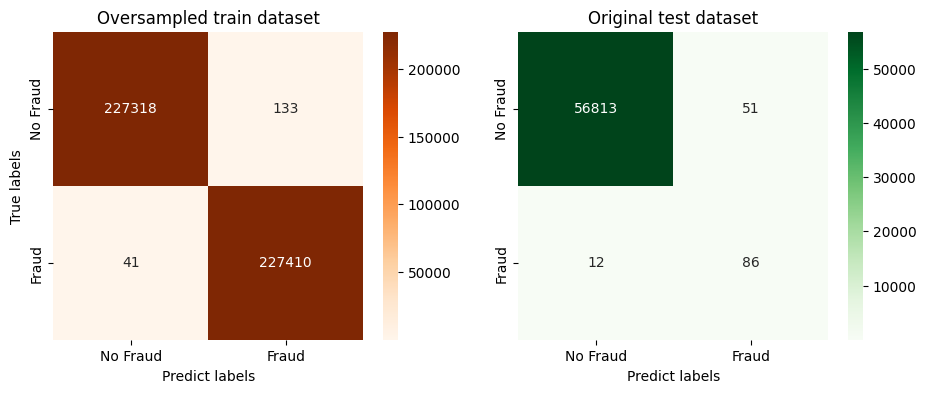

In [ ]:
labels = ['No Fraud', 'Fraud']
fig = plt.figure(figsize=(11, 4))
fig.tight_layout(pad=5.0)

ax1 = plt.subplot(1, 2, 1)
sns.heatmap(nn_cf_train, annot=True, fmt='.0f', ax=ax1, cmap=plt.cm.Oranges)
ax1.set_xlabel('Predict labels')
ax1.set_ylabel('True labels')
ax1.set_xticklabels(labels=labels)
ax1.set_yticklabels(labels=labels, rotation = 90)
ax1.set_title('Oversampled train dataset')

ax2 = plt.subplot(1, 2, 2)
sns.heatmap(nn_cf_test, annot=True, fmt='.0f', ax=ax2, cmap=plt.cm.Greens)
ax2.set_xlabel('Predict labels')
ax2.set_xticklabels(labels=labels)
ax2.set_yticklabels(labels=labels, rotation = 90)
ax2.set_title('Original test dataset')

plt.subplots_adjust(wspace=0.2)
plt.show()

In [ ]:
print('Classification report: \n')
print('Oversampled train dataset:')
print(classification_report(train_dataset.y, nn_ytrain_pred))
print('\nOriginal test dataset:')
print(classification_report(test_dataset.y, nn_ytest_pred))

Classification report: 

Oversampled train dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902


Original test dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.63      0.88      0.73        98

    accuracy                           1.00     56962
   macro avg       0.81      0.94      0.87     56962
weighted avg       1.00      1.00      1.00     56962



# 7.Conclusion

SMOTE oversampling algorithm help machine learning models on imbalance dataset return better prediction on minority classes. After the consideration of four algorithms (K-Nearest Neighbors, Random Forest, XGBoost, Logistic Regression), Random Forest and XGBoost give better evaluation on Fraud transactions classification.

Because of the importance of the detection of fraud transaction, the prediction probability can be adjust to ensure that transactions with high fraud probability need to be paid more attention. Thus, some misclassified non-fraud transactions might be accepted.

Furthermore, Neural Network model unlikely return outstanding prediction compared to other models.